In [1]:
import json
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import norse
import matplotlib.pyplot as plt

In [2]:
### TEST DATA
test_data_path = "data/ds_test.pt"
ds_test = torch.load(test_data_path)

letter_written = ['Space', 'A', 'E', 'I', 'O', 'U', 'Y']
device = "cpu"
### LOSS FUNCTION
loss_fn = torch.nn.functional.cross_entropy
### OPTIMAL HYPERPARAMETERS
parameters_path = "data/parameters_ref_zero.json"

with open(parameters_path) as f:
   parameters = json.load(f)

In [3]:
import nir
nir_graph = nir.read("braille_noDelay_noBias_subtract.nir")
nir_graph.nodes.keys()

dict_keys(['fc1', 'fc2', 'input', 'lif1.lif', 'lif1.w_rec', 'lif2', 'output'])

In [4]:
nir_graph = nir.read("braille_noDelay_bias_zero.nir")
nir_graph.nodes["lif1.lif"]

CubaLIF(tau_syn=array([0.00022222, 0.00022222, 0.00022222, 0.00022222, 0.00022222,
       0.00022222, 0.00022222, 0.00022222, 0.00022222, 0.00022222,
       0.00022222, 0.00022222, 0.00022222, 0.00022222, 0.00022222,
       0.00022222, 0.00022222, 0.00022222, 0.00022222, 0.00022222,
       0.00022222, 0.00022222, 0.00022222, 0.00022222, 0.00022222,
       0.00022222, 0.00022222, 0.00022222, 0.00022222, 0.00022222,
       0.00022222, 0.00022222, 0.00022222, 0.00022222, 0.00022222,
       0.00022222, 0.00022222, 0.00022222]), tau_mem=array([0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001,
       0.001, 0.001]), r=array([9.99999762, 9.99999762, 9.99999762, 9.99999762, 9.99999762,
       9.99999762, 9.99999762, 9.99999762, 9.99999762, 9.99999762,
       9.99999762, 9.99

In [5]:
(0.00022222)

0.00022222

In [6]:
1 / 0.00022222222222222

4500.000000000045

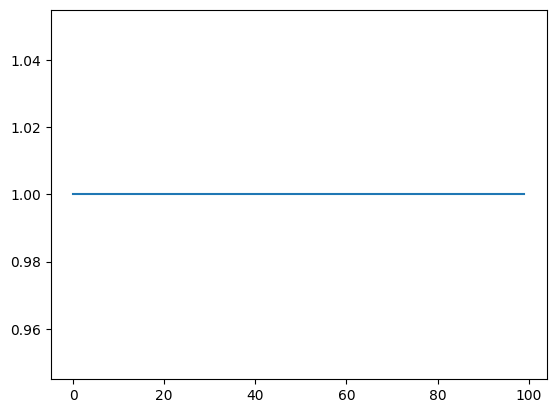

In [7]:
t = torch.ones(100, 1)
out = []
state = None
c = norse.torch.LIBoxCell(p=norse.torch.LIParameters(tau_mem_inv=10000), dt=1e-4)
for x in t:
    y, state = c(x, state)
    out.append(y.detach())
plt.plot(out)

In [8]:
[type(x) for x in nir_graph.nodes.values()]

[nir.ir.Affine,
 nir.ir.Affine,
 nir.ir.Input,
 nir.ir.CubaLIF,
 nir.ir.Affine,
 nir.ir.CubaLIF,
 nir.ir.Output]

In [9]:
1 / 1e-3

1000.0

In [10]:
net = norse.torch.from_nir(nir_graph, dt=1e-4)
net

GraphExecutor(
  (fc1): Linear(in_features=12, out_features=38, bias=True)
  (fc2): Linear(in_features=38, out_features=7, bias=True)
  (input): Identity()
  (lif1_lif): CubaLIF(
    (synapse): LIBoxCell(
      p=LIBoxParameters(tau_mem_inv=tensor([4500., 4500., 4500., 4500., 4500., 4500., 4500., 4500., 4500., 4500.,
              4500., 4500., 4500., 4500., 4500., 4500., 4500., 4500., 4500., 4500.,
              4500., 4500., 4500., 4500., 4500., 4500., 4500., 4500., 4500., 4500.,
              4500., 4500., 4500., 4500., 4500., 4500., 4500., 4500.]), v_leak=tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
              0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])), dt=0.0001
    )
    (lif): LIFBoxCell(
      p=LIFBoxParameters(tau_mem_inv=tensor([1000.0002, 1000.0002, 1000.0002, 1000.0002, 1000.0002, 1000.0002,
              1000.0002, 1000.0002, 1000.0002, 1000.0002, 1000.0002, 1000.0002,
              1000.0002, 10

In [11]:
nir_graph.nodes.keys()

dict_keys(['fc1', 'fc2', 'input', 'lif1.lif', 'lif1.w_rec', 'lif2', 'output'])

# Save activity of first layer

In [19]:
def record_layer1(graph, reset_method):
    net = norse.torch.from_nir(graph, dt=1e-4, reset_method=reset_method)
    lin_out = net.fc1(ds_test[0][0])
    # new_p = net.lif1_lif.lif.p._asdict()
    # new_p["tau_mem_inv"] = new_p["tau_mem_inv"] * 0.1
    # net.lif1_lif.lif.p = norse.torch.LIFBoxParameters(**new_p)
    # new_p = net.lif1_lif.synapse.p._asdict()
    # new_p["tau_mem_inv"] = new_p["tau_mem_inv"]
    # net.lif1_lif.synapse.p = norse.torch.LIBoxParameters(**new_p)
    lif1_out = []
    vs = []
    state = None
    for i, t in enumerate(lin_out):
        if i == 0:
            rec_in = t + net.lif1_w_rec(torch.zeros_like(t))
        else:
            rec_in = t + net.lif1_w_rec(lif1_out[-1])
        z, state = net.lif1_lif(t, state)
        vs.append(state)
        lif1_out.append(z)
    return torch.stack(lif1_out).detach(), vs
zero_out, vs = record_layer1("braille_noDelay_bias_zero.nir", reset_method=norse.torch.functional.reset_value)
zero_out.shape
vs
# plt.imshow(zero_out.T, interpolation="none", aspect=4)

[(LIBoxState(v=tensor([-0.0666, -0.0627,  0.1163, -0.4714, -0.6731, -0.0239, -0.1922, -1.0749,
          -0.6326, -1.6949, -0.1950, -0.9372, -0.0299, -0.0702,  0.2162, -0.1412,
          -0.0670, -0.3533, -1.3150,  0.1799, -0.6817, -1.4427, -0.4635, -0.1893,
          -0.3267,  0.0136, -0.4383,  0.0415, -1.2569, -0.4215, -0.6471, -0.3831,
           0.1598,  0.2515, -0.1971, -0.2372, -0.1308,  0.0619],
         grad_fn=<AddBackward0>)),
  LIFBoxFeedForwardState(v=tensor([-0.0666, -0.0627,  0.1163, -0.4714, -0.6731, -0.0239, -0.1922, -1.0749,
          -0.6326, -1.6949, -0.1950, -0.9372, -0.0299, -0.0702,  0.2162, -0.1412,
          -0.0670, -0.3533, -1.3150,  0.1799, -0.6817, -1.4427, -0.4635, -0.1893,
          -0.3267,  0.0136, -0.4383,  0.0415, -1.2569, -0.4215, -0.6471, -0.3831,
           0.1598,  0.2515, -0.1971, -0.2372, -0.1308,  0.0619],
         grad_fn=<AddBackward0>))),
 (LIBoxState(v=tensor([-0.1032, -0.0972,  0.1802, -0.7306, -1.0434, -0.0370, -0.2979, -1.6661,
          

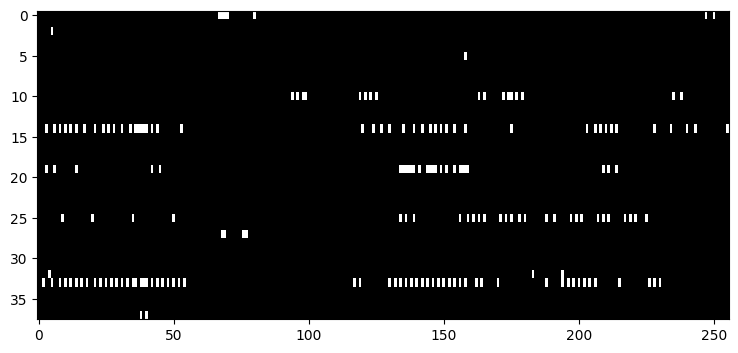

In [20]:
plt.figure(figsize=(12, 4))
plt.imshow(zero_out.T, aspect=3, interpolation="none", cmap="gray")

In [21]:
np.save("norse_activity_noDelay_bias_zero.npy", zero_out.numpy())

In [22]:
subtract_out, _ = record_layer1("braille_noDelay_noBias_subtract.nir", reset_method=norse.torch.functional.reset_subtract)
np.save("norse_activity_noDelay_noBias_subtract.npy", subtract_out.numpy())
subtract_out.shape

torch.Size([256, 40])

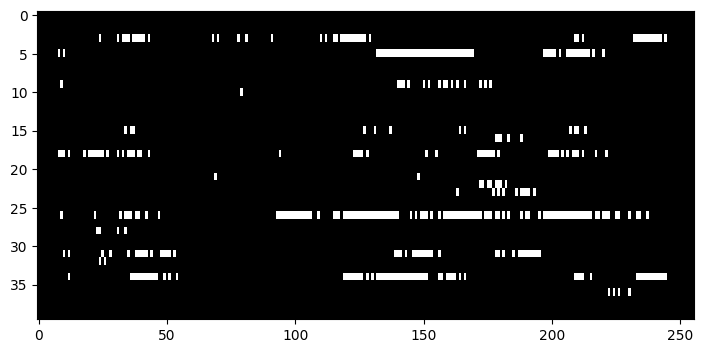

In [35]:
plt.figure(figsize=(12, 4))
plt.imshow(subtract_out.T, aspect=3, interpolation="none", cmap="gray")

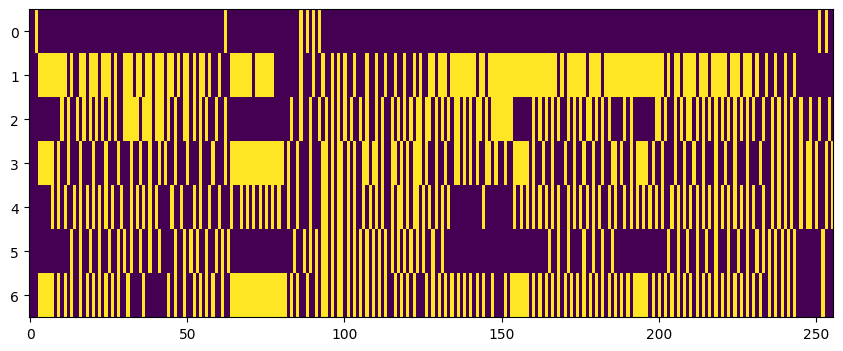

In [23]:
def apply(net, data):
    state = None
    hid_rec = []
    out = []
    for i, t in enumerate(data):
        z, state = net(t, state)
        out.append(z)
        hid_rec.append(state)
    spk_out = torch.stack(out)
    # hid_rec = torch.stack(hid_rec)
    return spk_out, hid_rec
plt.figure(figsize=(12, 4))
plt.imshow(apply(net, ds_test[0][0])[0].detach().T, aspect=14, interpolation="none")

# Run inference

In [29]:
def val_test_loop(dataset, batch_size, net, loss_fn, device, shuffle=True, saved_state_dict=None, label_probabilities=False, regularization=None):
  
  with torch.no_grad():
    if saved_state_dict != None:
        net.load_state_dict(saved_state_dict)
    net.eval()

    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, drop_last=False)

    batch_loss = []
    batch_acc = []

    for data, labels in loader:
        data = data.to(device).swapaxes(1, 0)
        labels = labels.to(device)

        spk_out, hid_rec = apply(net, data)

        # Validation loss
        if regularization != None:
            # L1 loss on spikes per neuron from the hidden layer
            reg_loss = regularization[0]*torch.mean(torch.sum(hid_rec, 0))
            # L2 loss on total number of spikes from the hidden layer
            reg_loss = reg_loss + regularization[1]*torch.mean(torch.sum(torch.sum(hid_rec, dim=0), dim=1)**2)
            loss_val = loss_fn(spk_out, labels) + reg_loss
        else:
            loss_val = loss_fn(spk_out.sum(0), labels)

        batch_loss.append(loss_val.detach().cpu().item())

        # Accuracy
        act_total_out = torch.sum(spk_out, 0)  # sum over time
        _, neuron_max_act_total_out = torch.max(act_total_out, 1)  # argmax over output units to compare to labels
        batch_acc.extend((neuron_max_act_total_out == labels).detach().cpu().numpy()) # batch_acc.append(np.mean((neuron_max_act_total_out == labels).detach().cpu().numpy()))
    
    if label_probabilities:
        log_softmax_fn = nn.LogSoftmax(dim=-1)
        log_p_y = log_softmax_fn(act_total_out)
        return [np.mean(batch_loss), np.mean(batch_acc)], torch.exp(log_p_y)
    else:
        return [np.mean(batch_loss), np.mean(batch_acc)]

In [30]:
### INFERENCE ON TEST SET

batch_size = 64

input_size = 12 
num_steps = next(iter(ds_test))[0].shape[0]
regularization = [parameters["reg_l1"], parameters["reg_l2"]]

In [31]:
def load_and_val(graph, reset_method):
    net = norse.torch.from_nir(graph, reset_method=reset_method, dt=1e-4)
    return val_test_loop(ds_test, batch_size, net, loss_fn, device, shuffle=False)#, regularization=regularization)    

In [32]:
test_results = load_and_val("braille_noDelay_noBias_subtract.nir", reset_method=norse.torch.functional.reset_subtract)
np.save("norse_accuracy_noDelay_noBias_subtract.npy", np.round(test_results[1]*100,2))
print("Test accuracy: {}%".format(np.round(test_results[1]*100,2)))

Test accuracy: 93.57%


In [33]:
test_results = load_and_val("braille_noDelay_bias_zero.nir", reset_method=norse.torch.functional.reset_value)
np.save("norse_accuracy_noDelay_bias_zero.npy", np.round(test_results[1]*100,2))
print("Test accuracy: {}%".format(np.round(test_results[1]*100,2)))

Test accuracy: 94.29%
